In [20]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [21]:
#!/bin/bash
!kaggle datasets download cienciacafeto/coffee-fruit-maturity

Dataset URL: https://www.kaggle.com/datasets/cienciacafeto/coffee-fruit-maturity
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
coffee-fruit-maturity.zip: Skipping, found more recently modified local copy (use --force to force download)


In [22]:
#Importing required libraries
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [23]:
with zipfile.ZipFile('/content/coffee-fruit-maturity.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [24]:
!pip install tensorflow

In [29]:
# Import necessary libraries for processing, modeling, and visualization
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image  # For image processing


**Preprocessing Images**

In [40]:
# Define paths to training, validation, and testing image directories
train_set = '/content/Coffee Fruit Maturity ---.v1i.yolov8/train'
valid_set = '/content/Coffee Fruit Maturity ---.v1i.yolov8/valid'
test_set = '/content/Coffee Fruit Maturity ---.v1i.yolov8/test'

# Define image size and batch size
img_size = (128, 128)
batch_size = 32

# Function to load and preprocess images (resize and normalize)
def load_and_preprocess_image(img_path):
    img = Image.open(img_path).resize(img_size)  # Resize to 128x128
    img = np.array(img) / 255.0  # Normalize pixel values to [0,1]
    return img

**Loading Training, Validation, and Testing Data**

In [41]:
# Create an ImageDataGenerator for the training set with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [42]:
# Create an ImageDataGenerator for validation and testing (only rescaling)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [43]:
# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'  # Or 'binary' if you have only two classes
)

validation_generator = validation_datagen.flow_from_directory(
    valid_set,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_set,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 600 images belonging to 2 classes.
Found 174 images belonging to 2 classes.
Found 85 images belonging to 2 classes.


**Visualization**

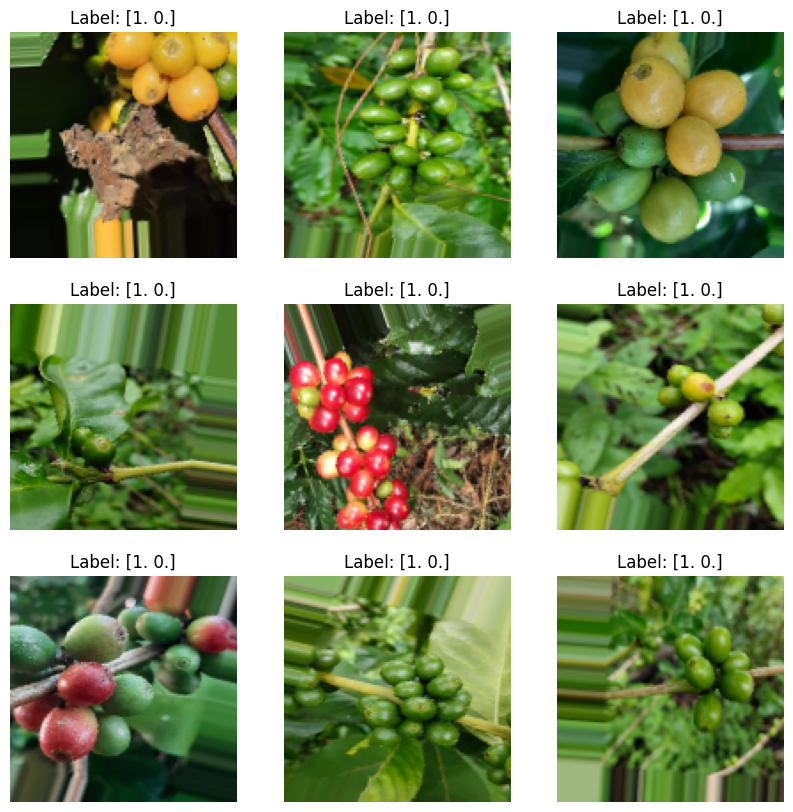

In [45]:

# Get a batch of images and labels from the training generator
images, labels = next(train_generator)

# Display some sample images with their labels
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.show()

Image shape: (32, 128, 128, 3)
Label shape: (32, 2)
Image data type: float32
Label data type: float32


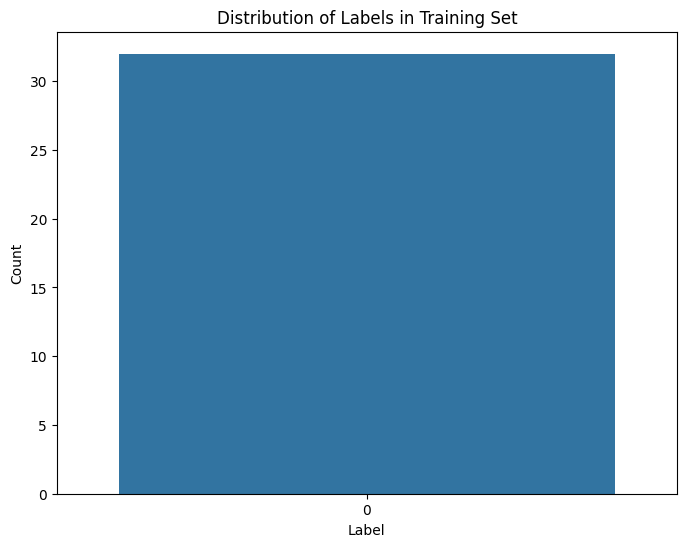

In [49]:

# Analyze image shapes and data types
print("Image shape:", images.shape)
print("Label shape:", labels.shape)
print("Image data type:", images.dtype)
print("Label data type:", labels.dtype)

# Convert one-hot encoded labels to class indices
label_indices = np.argmax(labels, axis=1)
# Create pandas Series from the class indices
label_counts = pd.Series(label_indices).value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Distribution of Labels in Training Set")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [50]:
# Calculate the mean and standard deviation of pixel values for each channel (RGB)
mean_pixel_values = np.mean(images, axis=(0, 1, 2))
std_pixel_values = np.std(images, axis=(0, 1, 2))
print("Mean Pixel Values:", mean_pixel_values)
print("Standard Deviation of Pixel Values:", std_pixel_values)

Mean Pixel Values: [0.3736958  0.45900372 0.22199757]
Standard Deviation of Pixel Values: [0.22181933 0.21221119 0.19075559]


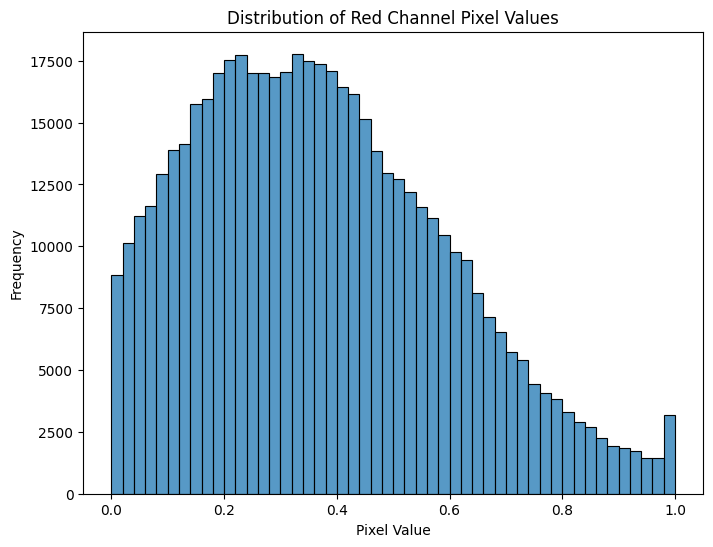

In [51]:
# Analyze the distribution of pixel values for a specific channel (e.g., Red)
red_channel_values = images[:, :, :, 0].flatten()
plt.figure(figsize=(8, 6))
sns.histplot(red_channel_values, bins=50)
plt.title("Distribution of Red Channel Pixel Values")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

**Building the CNN Model**

In [53]:
from tensorflow.keras import layers, models , regularizers
from tensorflow.keras.layers import Dropout

In [54]:
# Build CNN model with regularization and dropout
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.25),  # Add dropout after the first MaxPooling layer
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.25),  # Add dropout after the second MaxPooling layer
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    Dropout(0.25),  # Add dropout after the third MaxPooling layer
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),  # Add dropout before the output layer
    layers.Dense(train_generator.num_classes, activation='softmax')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [57]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
# Train the model using the training data and validate using validation data
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20  # Adjust the number of epochs as needed
)

Epoch 1/20
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 0.3271

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - accuracy: 1.0000 - loss: 0.3254 - val_accuracy: 1.0000 - val_loss: 0.2898
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 0.2789 - val_accuracy: 1.0000 - val_loss: 0.2485
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 0.2398 - val_accuracy: 1.0000 - val_loss: 0.2165
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 0.2099 - val_accuracy: 1.0000 - val_loss: 0.1913
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 0.1857 - val_accuracy: 1.0000 - val_loss: 0.1706
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 0.1661 - val_accuracy: 1.0000 - val_loss: 0.1532
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 0.1493 - val_accuracy: 1.0000 - val_loss: 0.1382
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 0.1349 - val_accuracy: 1.0000 - val_

In [61]:
#Model Evaluation on train set
train_loss,train_acc = model.evaluate(test_generator)

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0445 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 765ms/step - accuracy: 1.0000 - loss: 0.0445


In [63]:
#model Evaluation on valid set
val_loss,val_acc = model.evaluate(validation_generator)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0445


In [64]:
model.save("fruitCNN_model.h5")

In [65]:
model.save("fruitCNN_model.keras")

**Model Evaluation (Confusion Matrix and Metrics)**

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
              precision    recall  f1-score   support

      images       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


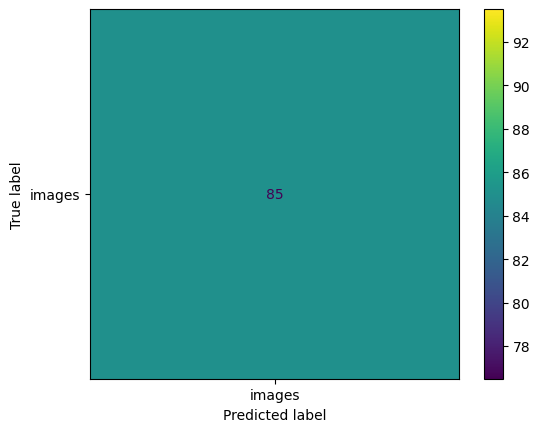

In [67]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np

# Predict on test data
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels from test data
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Get the actual class labels present in y_true and y_pred_classes
# This ensures labels match the confusion matrix dimensions
unique_labels = np.unique(np.concatenate((y_true, y_pred_classes)))
display_labels = [k for k, v in test_generator.class_indices.items() if v in unique_labels]

cmd = ConfusionMatrixDisplay(cm, display_labels=display_labels)
cmd.plot()

# Classification report
# Use the same display_labels for consistency
print(classification_report(y_true, y_pred_classes, target_names=display_labels))

In [68]:
# saving model to drive
model.save('/content/drive/MyDrive/fruitCNN_model.keras')
model.save('/content/drive/MyDrive/fruitCNN_model.h5')

In [70]:
history.history

{'accuracy': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'loss': [0.31528979539871216,
  0.2695748507976532,
  0.2324409782886505,
  0.2042364627122879,
  0.1810142546892166,
  0.16208694875240326,
  0.14586444199085236,
  0.13196584582328796,
  0.11971927434206009,
  0.10886796563863754,
  0.0993046835064888,
  0.09069279581308365,
  0.08309616148471832,
  0.0762128233909607,
  0.06998130679130554,
  0.0643099844455719,
  0.05918503552675247,
  0.054526373744010925,
  0.050296030938625336,
  0.046362265944480896],
 'val_accuracy': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.28980645537376404,
  0.2484559267759323,
  0.2164856642484665,
  0.1912563294172287,
  0.17058180272579193,
  0.15316081047058105,
  0.1382025182247162,
  0.12518948316574097,
  0.11375901848077774,
  0.103642

**Accuracy Visualization**

In [74]:
epochs = [i for i in range(1,21)]
epochs

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

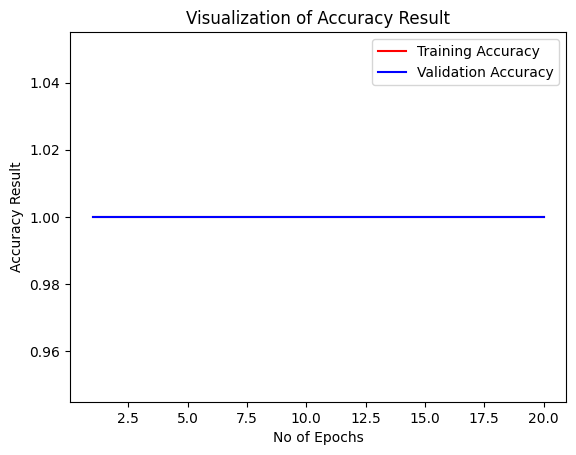

In [79]:
# Generate a list of epoch numbers corresponding to the training history
epochs = [i for i in range(1, len(history.history['accuracy']) + 1)]

# Plot the training and validation accuracy against the epoch numbers
plt.plot(epochs, history.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.xlabel("No of Epochs")
plt.ylabel("Accuracy Result")
plt.title("Visualization of Accuracy Result")
plt.legend()
plt.show()

In [92]:
train_generator = train_datagen.flow_from_directory(
    valid_set,
    target_size=(128, 128), # Replace with your image dimensions
    batch_size=32, # Replace with your batch size
    class_mode='categorical' # Or other relevant mode like 'binary'
)

class_names = train_generator.class_indices # Access class_indices from train_generator
# To get a list of class names:
class_names_list = list(class_names.keys())
print(class_names_list)

Found 174 images belonging to 2 classes.
['images', 'labels']


In [94]:
y_pred = model.predict(train_generator )
y_pred,y_pred.shape

1/6 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step


(array([[9.99999762e-01, 2.63099082e-07],
        [9.99999642e-01, 3.26569477e-07],
        [9.99999046e-01, 9.09245102e-07],
        [9.99999285e-01, 7.61090803e-07],
        [9.99999404e-01, 6.41226222e-07],
        [9.99997854e-01, 2.12537202e-06],
        [9.99999762e-01, 2.09470414e-07],
        [9.99999642e-01, 3.54283344e-07],
        [9.99999404e-01, 5.62588639e-07],
        [9.99999404e-01, 6.45981231e-07],
        [9.99998212e-01, 1.73843148e-06],
        [9.99999404e-01, 6.48328921e-07],
        [9.99966383e-01, 3.35885925e-05],
        [9.99999642e-01, 3.06143249e-07],
        [9.99999166e-01, 8.20607681e-07],
        [9.99999881e-01, 1.72635808e-07],
        [9.99998450e-01, 1.57283262e-06],
        [9.99999404e-01, 5.67181758e-07],
        [9.99976397e-01, 2.35751340e-05],
        [9.99998689e-01, 1.27509952e-06],
        [9.99974251e-01, 2.57638112e-05],
        [9.99991417e-01, 8.54857899e-06],
        [9.99997616e-01, 2.34779554e-06],
        [9.99980569e-01, 1.9377297